In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


# Training Notebook
this notebook is suppose to run in kaggle environment, due to the kaggle competition rule the data is only available for competition participants, therefore we are not download the data for local training. 

In [2]:
!pip install -q segmentation_models_pytorch

In [3]:
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
from glob import glob
import gc
import time
from collections import defaultdict
import  matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import copy
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.cuda import amp
import torch.optim as optim
import albumentations as A
import segmentation_models_pytorch as smp

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# File preparation
1. get all training / validation images/masks directory
2. don't spend too much time on validation 

In [4]:
from sklearn.model_selection import train_test_split

In [5]:

base_path = '/kaggle/input/blood-vessel-segmentation/train'  
train_base_path = '/kaggle/input/patched-sennet-kidney-1-data'

# train_dataset = ['kidney_1_dense'] #,'kidney_2']
val_img = 'kidney_3_sparse'
val_mask = 'kidney_3_sparse'

image_train_files = []
label_train_files = []


# for dataset in train_dataset:

# images_path = os.path.join(train_base_path, dataset, 'images')
# labels_path = os.path.join(train_base_path, dataset, 'labels')
# images_path = '/kaggle/input/800x800kidney2/train_k1_patch800_img'
# labels_path = '/kaggle/input/800x800kidney2/train_k1_patch800_msk'
images_path = '/kaggle/input/800x800kidney2/train_k1_patch800_img'
labels_path = '/kaggle/input/800x800kidney2/train_k1_patch800_msk'
image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])
image_train_files.extend(image_files)
label_train_files.extend(label_files)
image_train_files = image_train_files[3000:12000]
label_files = label_files[3000:12000]
print(f'len of image path {len(image_train_files)}')
X_train, X_val, y_train, y_val = train_test_split(image_train_files, label_files, test_size=0.3)

images_val_path = os.path.join(base_path, val_img, 'images')
labels_val_path = os.path.join(base_path, val_mask, 'labels')
image_val_files = sorted([os.path.join(images_val_path, f) for f in os.listdir(images_val_path) if f.endswith('.tif')])
label_val_files = sorted([os.path.join(labels_val_path, f) for f in os.listdir(labels_val_path) if f.endswith('.tif')])
# image_val_files = image_val_files[1000:1500]
# label_val_files = label_val_files[1000:1500]
print(f"len of val path {len(image_val_files)}")
print(len(label_val_files))

len of image path 9000
len of val path 1035
1035


In [6]:
class CFG:
    backbone = "resnext50_32x4d"
    train_bs = 6
    valid_bs = 24
    img_size = [800,800]
    epochs = 2
    lr = 1e-3
    over_lap = 0.2
    patch_size = 800
    bin_path = '/kaggle/input/resnext-k1-2/resnext_800k12.bin'

    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    data_transforms = {
        "train": A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ], p=1.0),
        
        "valid": A.Compose([
        ], p=1.0)
    }
    

# Dataloader:
this dataloader return the original size for testing 

In [7]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED) 
    msk = msk.astype('float32')
    msk/=255.0
    return msk

In [8]:

# img = load_img('/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/1000.tif')
# msk = load_msk('/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels/1000.tif')
# print(img.shape)
# plt.figure(figsize=(9, 4))
# plt.axis('off')
# plt.subplot(1,3,1)
# plt.imshow(img)
# plt.subplot(1,3,2)
# plt.imshow(msk)
# plt.subplot(1,3,3)
# plt.imshow(img, cmap='bone')
# plt.imshow(msk, alpha=0.5)

In [9]:
# for image: h,w

# def save_patches(img, patch_s,directory, name, over_lap = 0.1):
#     l = []
#     width = img.shape[1]
#     height = img.shape[0]
#     max_stride = patch_s * (1-over_lap)
#     num_patches = np.ceil(np.array([height, width]) / max_stride).astype(np.int64)
#     starts = [np.int64(np.linspace(0, width - patch_s, num_patches[1])),
#                           np.int64(np.linspace(0, height - patch_s, num_patches[0]))]
#     stops = [starts[0] + patch_s, starts[1] +patch_s]
#     for y1, y2 in zip(starts[1], stops[1]):
#         for x1, x2 in zip(starts[0], stops[0]):
#             this_region = img[y1:y2, x1:x2]
#             l.append(this_region)
    
#     # save the images: 
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     for i in range(len(l)):
#         file_path = os.path.join(directory,f'{name}_{i}.tif')
#         cv2.imwrite(file_path,l[i])
        



# create patched dataset

In [10]:
# for i, path in enumerate(image_train_files):
#     img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
#     save_patches(img,512,'train5_img',name = f"kidney_1_img_{i}")
# for i, path in enumerate(label_train_files):
#     msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
#     save_patches(msk,512,'train5_msk',name = f"kidney_1_msk_{i}")


## warning
dataset may has the chance of loading empty images, which is weird, but need way to handle that 
1. create a checking loop, to check which file cause error then remove the file. 

In [11]:
# error_file_pairs = []
# for i in range(len(image_train_files)):
#     img_path = image_train_files[i]
#     msk_path = label_train_files[i]
#     try: 
#         load_img(img_path)
#         load_msk(msk_path)
#     except Exception as e:
#         print(f"error image and msk path is {img_path}, and {msk_path}")
#         error_file_pairs.append((img_path,msk_path))

        

In [12]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, msk_paths=[], transforms=None):
        self.img_paths  = img_paths
        self.msk_paths  = msk_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = load_img(img_path)
        
        if len(self.msk_paths)>0:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            orig_size = img.shape
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), torch.tensor(np.array([orig_size[0], orig_size[1]]))

In [13]:
#X_train, X_val, y_train, y_val
# image_val_files = sorted([os.path.join(images_val_path, f) for f in os.listdir(images_val_path) if f.endswith('.tif')])
# label_val_files
train_dataset = BuildDataset(X_train, y_train, transforms=CFG.data_transforms['train'])
valid_dataset = BuildDataset(X_val, y_val, transforms=None)
psudo_test_dataset = BuildDataset(image_val_files,label_val_files,transforms=None)
train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True)
psudo_test_loader = DataLoader(psudo_test_dataset, batch_size=1, num_workers=0, shuffle=False, pin_memory=True)

# Sanity check

torch.Size([3, 800, 800])
torch.Size([800, 800])


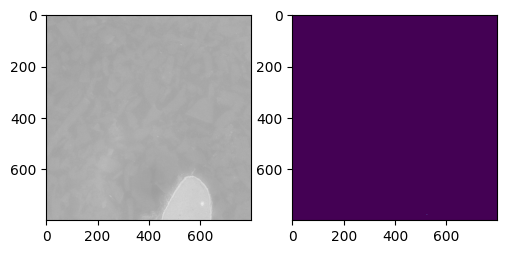

torch.Size([3, 800, 800])
torch.Size([800, 800])


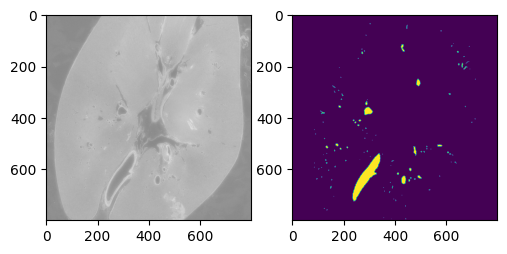

torch.Size([3, 800, 800])
torch.Size([800, 800])


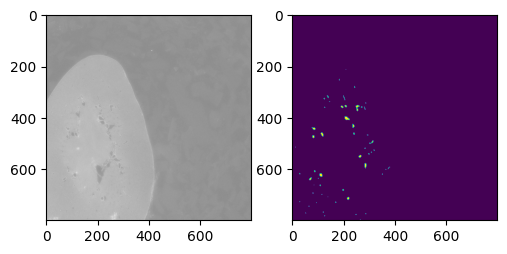

torch.Size([3, 800, 800])
torch.Size([800, 800])


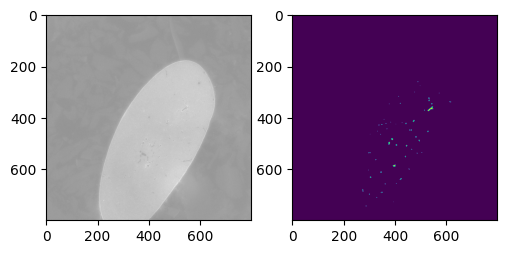

torch.Size([3, 800, 800])
torch.Size([800, 800])


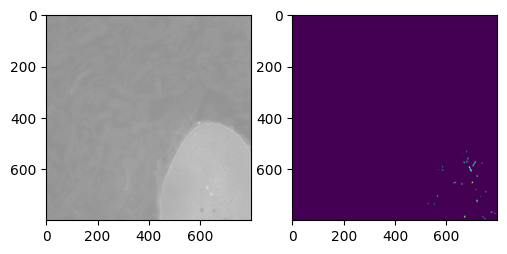

torch.Size([3, 800, 800])
torch.Size([800, 800])


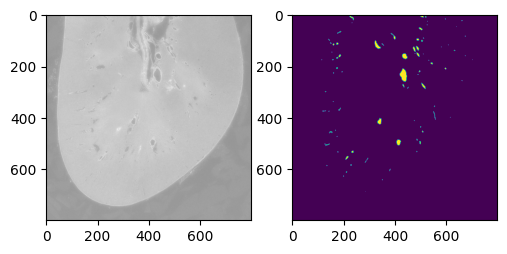

torch.Size([3, 800, 800])
torch.Size([800, 800])


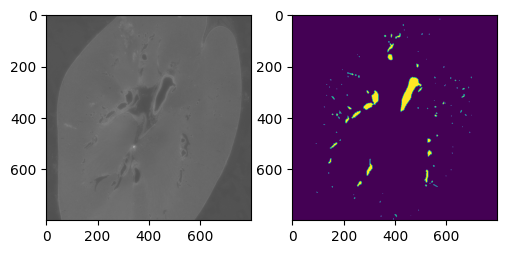

torch.Size([3, 800, 800])
torch.Size([800, 800])


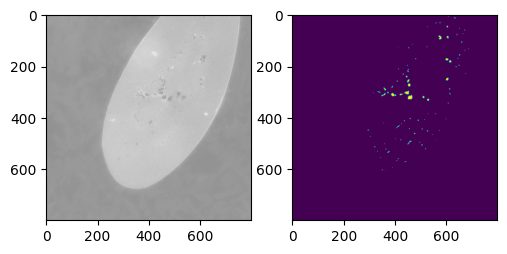

torch.Size([3, 800, 800])
torch.Size([800, 800])


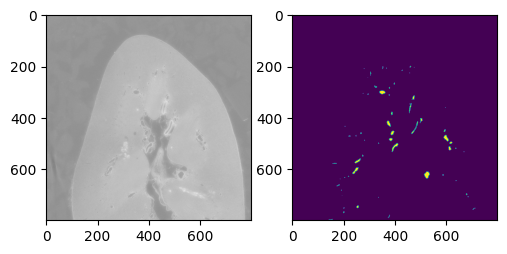

torch.Size([3, 800, 800])
torch.Size([800, 800])


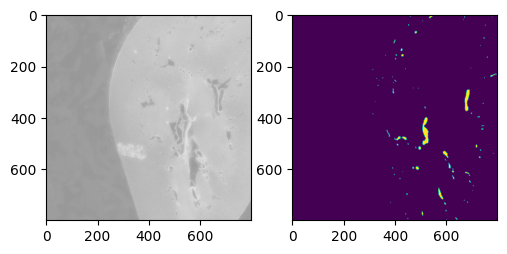

torch.Size([3, 800, 800])
torch.Size([800, 800])


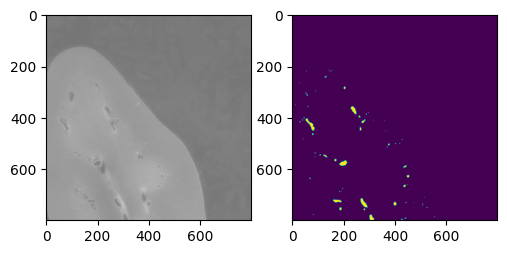

torch.Size([3, 800, 800])
torch.Size([800, 800])


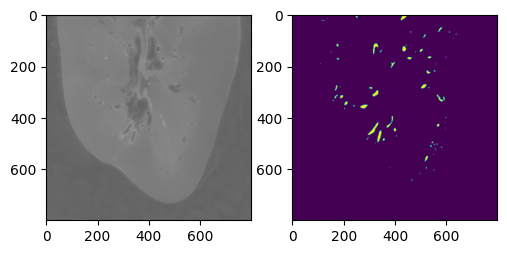

torch.Size([3, 800, 800])
torch.Size([800, 800])


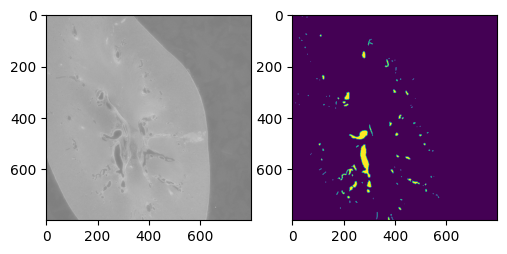

torch.Size([3, 800, 800])
torch.Size([800, 800])


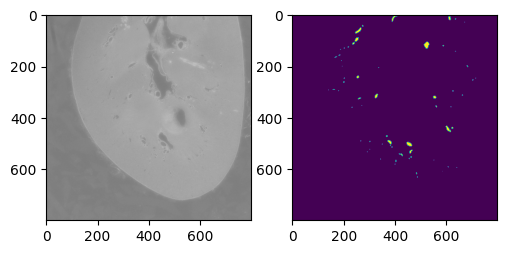

torch.Size([3, 800, 800])
torch.Size([800, 800])


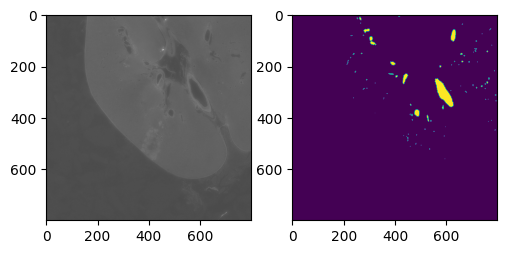

torch.Size([3, 800, 800])
torch.Size([800, 800])


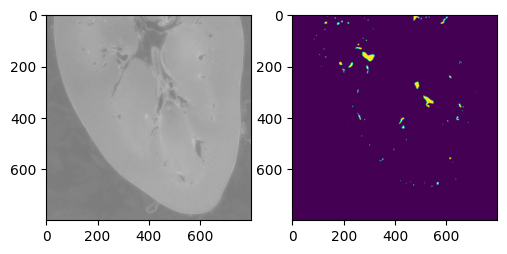

torch.Size([3, 800, 800])
torch.Size([800, 800])


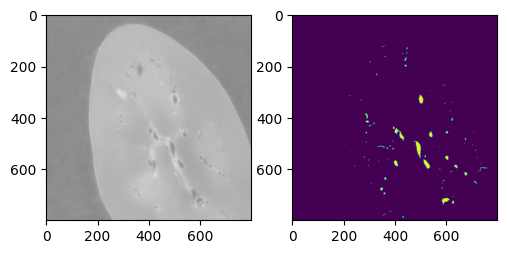

torch.Size([3, 800, 800])
torch.Size([800, 800])


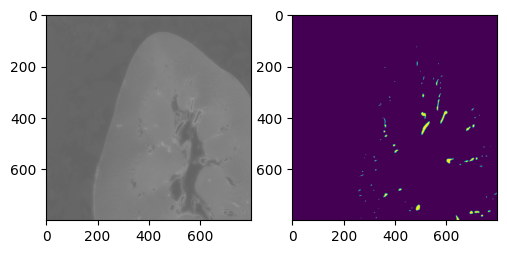

torch.Size([3, 800, 800])
torch.Size([800, 800])


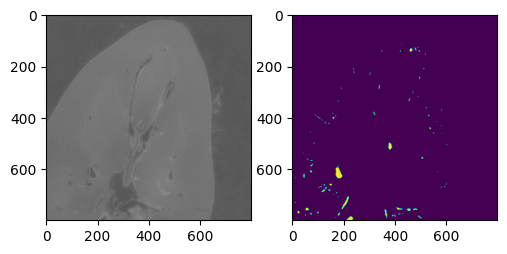

torch.Size([3, 800, 800])
torch.Size([800, 800])


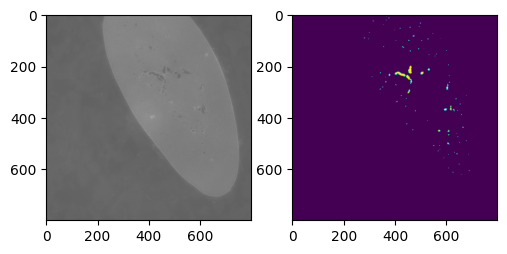

In [14]:
sample_ids = [random.randint(0, len(train_dataset)) for _ in range(20)]
for id in sample_ids:
    img, msk =  train_dataset[id]
    print(img.shape)
    print(msk.shape)
    img = img.permute((1, 2, 0)).numpy()*255.0
    img = img.astype('uint8')
    msk = (msk).numpy().astype('uint8')
#     print(img.shape)
#     print(msk.shape)
    plt.figure(figsize=(9, 4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(msk)
    plt.show()
#     msks = patch_image(msk,512)
#     for i in msks: 
#         print(i.shape)
#     ori_shape =msk.shape
#     c_m = combine_patches(msks,original_shape = ori_shape,patch_size = 512)
#     plt.subplot(1,3,3)
#     plt.imshow(c_m)
#     plt.show()
    
    

resnet: https://arxiv.org/abs/1611.05431

In [15]:
# sample_ids = [random.randint(0, len(X_train)) for _ in range(5)]
# sample_psudotid = [random.randint(0, len(image_val_files)) for _ in range(5)]
# for i in range(len(sample_ids)):
#     img, msk = train_dataset[sample_ids[i]]
#     img = img.permute((1, 2, 0)).numpy()*255.0
#     img = img.astype('uint8')
#     msk = (msk*255).numpy().astype('uint8')
#     plt.figure(figsize=(9, 4))
    
#     p_img,p_msk = psudo_test_dataset[sample_psudotid[i]]
#     p_img = p_img.permute((1, 2, 0)).numpy()*255.0
#     p_img = p_img.astype('uint8')
#     p_msk = (p_msk*255).numpy().astype('uint8')
    
#     plt.axis('off')
#     plt.subplot(1,5,1)
#     plt.imshow(img)
#     plt.subplot(1,5,2)
#     plt.imshow(msk)
#     plt.subplot(1,5,3)
#     plt.imshow(img, cmap='bone')
#     plt.imshow(msk, alpha=0.5)
    
    
#     plt.subplot(1,5,4)
#     plt.imshow(p_img)
#     plt.subplot(1,5,5)
#     plt.imshow(p_msk)
#     plt.show()

In [16]:
def build_model(backbone, num_classes, device):
    model = smp.Unet(
        encoder_name=backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(backbone, num_classes, device, path):
    model = build_model(backbone, num_classes, device)
    model.load_state_dict(torch.load(path))
    return model

model = load_model(CFG.backbone, 
                   1, 
                   CFG.device, 
                   CFG.bin_path)
# model = build_model(
#     CFG.backbone,
#     num_classes = 1,
#     device = CFG.device
#     )

In [17]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

In [18]:
criterion = smp.losses.DiceLoss(mode='binary')


In [19]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
    
        y_pred = model(images)
        loss   = criterion(y_pred, masks)
        loss.backward()
        optimizer.step()

        # zero the parameter gradients
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix( epoch=f'{epoch}',
                          train_loss=f'{epoch_loss:0.4f}',
                          lr=f'{current_lr:0.5f}',
                          gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss

In [20]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss, val_scores

# pseudo test on performance

In [21]:

def patch_image(img, patch_size, model = None, over_lap=0.2):
    """
    Splits the image into patches with overlap.

    """
    shape = img.shape

    height, width = shape[2],shape[3]

    stride = patch_size * (1 - over_lap)
    num_patches = np.ceil(np.array([height, width]) / stride).astype(np.int64)
    starts = [np.int64(np.linspace(0, width - patch_size, num_patches[1])),
              np.int64(np.linspace(0, height - patch_size, num_patches[0]))]
    patches = []
    for y in starts[1]:
        for x in starts[0]:
            if model != None: 
                patch_img = img[:,:,y:y + patch_size, x:x + patch_size]
#                 print(type(patch_img)," and shape is ",patch_img.shape)
#                 print(f'inside the patch function: size of patched image: {np.shape(patch_img)}')
                patches.append(patch_img)
    patches = torch.cat(patches,dim = 0)
    pred = model(patches)
    return pred


def combine_patches_torch(patches, original_shape, patch_size, over_lap=0.1):
    height, width = original_shape[2],original_shape[3]
    stride = int(patch_size * (1 - over_lap))
    combined = np.zeros((height, width), dtype=np.float32)
    weight = np.zeros((height, width), dtype=np.float32)

    num_patches_y = np.ceil(height / stride).astype(np.int64)
    num_patches_x = np.ceil(width / stride).astype(np.int64)

    starts_y = np.linspace(0, height - patch_size, num_patches_y).astype(np.int64)
    starts_x = np.linspace(0, width - patch_size, num_patches_x).astype(np.int64)

    patch_idx = 0
    for y in starts_y:
        for x in starts_x:
            
            patch = patches[patch_idx].detach().cpu()
            patch = patch.numpy().astype(np.float32)
#             print(f'inside the combine function: type of combine = {type(combined)}, shape of patches = {np.shape(patch)}')
            # with torch, I cannot add different sized tensor together 
            combined[y:y + patch_size, x:x + patch_size] += patch.squeeze()
            weight[y:y + patch_size, x:x + patch_size] += 1.0
            patch_idx += 1

    # Avoid division by zero
    weight[weight == 0] = 1.0
    combined = combined / weight
    combined = torch.from_numpy(combined)
    combined = combined.unsqueeze(0).unsqueeze(0)
    
    return combined



In [22]:
@torch.no_grad()
def test_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        ori_shape = images.shape
        patches = patch_image(images,patch_size=CFG.patch_size,over_lap = CFG.over_lap,model = model)
        y_pred  = combine_patches_torch(patches,ori_shape,patch_size=CFG.patch_size,over_lap = CFG.over_lap)
        y_pred=y_pred.to(device, dtype=torch.float)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
      
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
        
    return epoch_loss, val_scores

In [23]:
from colorama import Fore, Back, Style #?
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

In [24]:
def run_training(model, optimizer, scheduler, device, num_epochs):    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss      = np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
#         test_loss, test_scores = test_one_epoch(model,
#                psudo_test_loader,
#                device=CFG.device,
#                epoch=epoch)
        val_dice, val_jaccard = val_scores
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        print(f'Valid Loss: {val_loss}')
#         print(f'pseudo test loss: {test_loss}')
        
        # deep copy the model
        if val_loss <= best_loss:
            print(f"{c_}Valid loss Improved ({best_loss} ---> {val_loss})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_loss = val_loss
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "best_epoch.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = "last_epoch.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [25]:
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = None
model, history = run_training(model, optimizer, scheduler,
                                device=CFG.device,
                                num_epochs=CFG.epochs)

cuda: Tesla P100-PCIE-16GB

Epoch 1/2

Valid : 100%|██████████| 113/113 [05:06<00:00,  2.71s/it, gpu_memory=10.06 GB, lr=0.00100, valid_loss=0.0449]


Valid Dice: 0.9261 | Valid Jaccard: 0.8757
Valid Loss: 0.0449020430776808
Valid loss Improved (inf ---> 0.0449020430776808)
Model Saved


Epoch 2/2

Valid : 100%|██████████| 113/113 [03:40<00:00,  1.95s/it, gpu_memory=10.22 GB, lr=0.00100, valid_loss=0.0453]


Valid Dice: 0.9208 | Valid Jaccard: 0.8694
Valid Loss: 0.04533377064598931


Training complete in 0h 56m 56s
Best Loss: 0.0449


In [26]:
test_loss, test_scores = test_one_epoch(model,
               psudo_test_loader,
               device=CFG.device,
               epoch=1)
print(test_loss)

Valid : 100%|██████████| 1035/1035 [13:35<00:00,  1.27it/s, gpu_memory=3.82 GB, lr=0.00100, valid_loss=0.8637]


0.8636512649807953
